In [124]:
import numpy as np
import pandas as pd
import os
import sqlite3
from nltk.corpus import stopwords
sw = stopwords.words('english')
sw2 = stopwords.words("english")
from string import punctuation
punctuation = set(punctuation)
punctuation.add("’")
import datetime
import time
from random import sample
import random
from IPython.display import Image

import tweepy
from tweepy import OAuthHandler
# I've put my API keys in a .py file called API_keys.py
from my_api_keys import api_key, api_key_secret, access_token, access_token_secret


import json
import csv
import re
import string
from collections import Counter, defaultdict
from pprint import pprint
from operator import itemgetter
import matplotlib.pyplot as plt



import pyLDAvis
import pyLDAvis.gensim_models
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,LdaMulticore, Phrases 
from gensim.models.phrases import Phraser 
from gensim.corpora import Dictionary
nlp = spacy.load('en_core_web_sm')
Lemmatizer = nlp.get_pipe("lemmatizer")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Authenticate the Tweepy API
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Modifications to punctuation and sw lists

punctuation = set(punctuation)
punctuation.add("’")

sw2 = set(sw)
addl = ("|","-","/","•","&", "&amp;")
sw2.update(addl)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####  Read daily tweets CSVs into pandas dataframe

In [5]:
db = pd.DataFrame(columns = ['user_id','screen_name','description','location','friends_count',
           'followers_count','totaltweets','date_created', 'tweet_id', 'retweetcount','full_text'])

file_location = "/Users/natebender/Desktop/Repo/text-mining/datashare_AA_COP_tweets/data/"
files = sorted(os.listdir(file_location))
for idx, file in enumerate(files):
    
    data = "".join([file_location,file])
    datafile = pd.read_csv(data)

    db = db.append(datafile,ignore_index=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(all_tweets) :

    all_desc = all_tweets.dropna()
    all_str = " ".join(all_desc)    
    clean = [w for w in all_str.split() if w.lower() not in sw2]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Introduction
This Acquire & Analyze workbook covers a topic modeling analysis and sentiment analysis of tweets related to the COP26 climate negotiations that took place from October 31st to November 12, 2021 in Glasgow, Scotland. 

Throughout the two weeks, the conference covered a number of climate themes on different days. My goal with this analysis is to uncover whether it is possible to find distinct groupings of tweets related to these themes, and, if that is possible, to track the sentiment of the distinct groupings throughout the conference. 

With any luck, these two analyses together will show how Twitter can be used to track distinct areas of discussion throughout an event, and see how the sentiment on Twitter for these areas evolves in reaction to the event. 

#### COP26 schedule

| Date  | Theme  | Description |
|---|---|---|
| 10/31 | COP begins | | 
| 11/01 | World leaders summit | A two-day event welcoming heads of state and inviting them to put forward their ambitions and proposals towards securing global net zero carbon emissions, keeping the 1.5C temperature increase target within reach, protecting ecosystems and mobilising finance | 
| 11/02 | World leaders summit | cont'd | 
| 11/03 | Finance | Mobilising public and private finance flows at scale for mitigation and adaptation | 
| 11/04 | Energy | Accelerating the global transition to clean energy | 
| 11/05 | Youth & public empowerment | Elevating the voice of young people and demonstrating the critical role of public empowerment and education in climate action | 
| 11/06 | Nature | Ensuring the importance of nature and sustainable land use are part of global action on climate change and a clean, green recovery | 
| 11/07 | Rest day |  | 
| 11/08 | Adaptation, loss and damage | Delivering the practical solutions solutions needed to adapt to climate impact and address loss and damage | 
| 11/09 | Gender, Science & Innovation | Progressing gender equality and the full and meaningful participation of women and girls in climate action. Demonstrating that research and technology can deliver climate solutions to meet, and accelerate, increased ambition | 
| 11/11 | Cities, regions and built environment | Advancing action in the places we live, from communities, through to cities and regions | 
| 11/12 | COP closes | | 

#### Descriptive stats on tweets
Let's first look at the descriptive stats for the tweets scraped

15k tweets were scraped from Twitter for each day of the conference if they included either hashtag "#cop26" or "#cop26glasgow" (or variations of those)

In [7]:
all_tweets = db.full_text.dropna()
print(f'Database: {"{:,}".format(len(db.tweet_id))} tweets')
print(f'Descriptive stats are:')
get_patterns(all_tweets)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Database: 285,084 tweets
Descriptive stats are:


{'tokens': 5523996,
 'unique_tokens': 170153,
 'avg_token_length': 7.82,
 'lexical_diversity': 0.03,
 'Top_n': [('#COP26', 227147),
  ('climate', 57446),
  ('#COP26Glasgow', 24133),
  ('world', 20434),
  ('#cop26', 18871),
  ('need', 18435),
  ('fossil', 17574),
  ('change', 15756),
  ('#Unknown', 15720),
  ('leaders', 14933),
  ('people', 13392),
  ('#ClimateAction', 13153),
  ('Climate', 12960),
  ('Glasgow', 12833),
  ('global', 11994),
  ('action', 11760),
  ('#ClimateCrisis', 11448),
  ('#COP26.', 10836),
  ('us', 10811),
  ('like', 10464)]}

In [8]:
import random
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from matplotlib.pyplot import text


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Subset dataframe to multiple 3-day windows

w1_text = db.full_text[(db['date_created']>= "2021-10-28") & (db['date_created']< "2021-10-29")]
w2_text = db.full_text[(db['date_created']>= "2021-10-29") & (db['date_created']< "2021-10-30")]
w3_text = db.full_text[(db['date_created']>= "2021-10-30") & (db['date_created']< "2021-10-31")]
w4_text = db.full_text[(db['date_created']>= "2021-10-31") & (db['date_created']< "2021-11-01")]
w5_text = db.full_text[(db['date_created']>= "2021-11-01") & (db['date_created']< "2021-11-02")]
w6_text = db.full_text[(db['date_created']>= "2021-11-02") & (db['date_created']< "2021-11-03")]
w7_text = db.full_text[(db['date_created']>= "2021-11-03") & (db['date_created']< "2021-11-04")]
w8_text = db.full_text[(db['date_created']>= "2021-11-04") & (db['date_created']< "2021-11-05")]
w9_text = db.full_text[(db['date_created']>= "2021-11-05") & (db['date_created']< "2021-11-06")]
w10_text = db.full_text[(db['date_created']>= "2021-11-06") & (db['date_created']< "2021-11-07")]
w11_text = db.full_text[(db['date_created']>= "2021-11-07") & (db['date_created']< "2021-11-08")]
w12_text = db.full_text[(db['date_created']>= "2021-11-08") & (db['date_created']< "2021-11-09")]
w13_text = db.full_text[(db['date_created']>= "2021-11-09") & (db['date_created']< "2021-11-10")]
w14_text = db.full_text[(db['date_created']>= "2021-11-10") & (db['date_created']< "2021-11-11")]
w15_text = db.full_text[(db['date_created']>= "2021-11-11") & (db['date_created']< "2021-11-12")]
w16_text = db.full_text[(db['date_created']>= "2021-11-12") & (db['date_created']< "2021-11-13")]
w17_text = db.full_text[(db['date_created']>= "2021-11-13") & (db['date_created']< "2021-11-14")]
w18_text = db.full_text[(db['date_created']>= "2021-11-14") & (db['date_created']< "2021-11-15")]
w19_text = db.full_text[(db['date_created']>= "2021-11-15") & (db['date_created']< "2021-11-16")]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Sets up sentiment scores dictionary

sentiment_scores = {}

with open("tidytext_sentiments.txt",'r') as infile :
    next(infile)
    for line in infile.readlines() :
        line = line.strip().split("\t")
        if line[1] == "positive" :
            sentiment_scores[line[0]] = 1
        else :
            sentiment_scores[line[0]] = -1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
dailytweets = [w1_text, w2_text, w3_text, w4_text, w5_text, w6_text, w7_text, w8_text, w9_text, w10_text,
              w11_text, w12_text, w13_text, w14_text, w15_text, w16_text, w17_text, w18_text, w19_text]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def sentiment_bywindow(timewindow) :
    tweets = list(timewindow)
    tweets_str = " ".join(tweets) 
    tweets_clean = [w for w in tweets_str.split() if w.lower() not in sw2]
    
    scores = []
    current_score = 0 

    for idx, word in enumerate(tweets_clean) :
        if word in sentiment_scores :
            current_score += sentiment_scores[word.lower()]
    
    scores.append(current_score)
        
#     filename = str(timewindow) + "_scores.csv"    
#     with open(filename,'w') as ofile :
#         ofile.write("word\tscore\n")
#         for idx, score in enumerate(scores) :
#             ofile.write("\t".join([str(idx+1),str(score)]) + "\n")
      
    return(scores)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
totalscores = []

for item in dailytweets:
    score = sentiment_bywindow(item)
    totalscores.append(score)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
anothergoddamnlist = []

for item in totalscores:
    anothergoddamnlist.append(item[0])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
import datetime
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


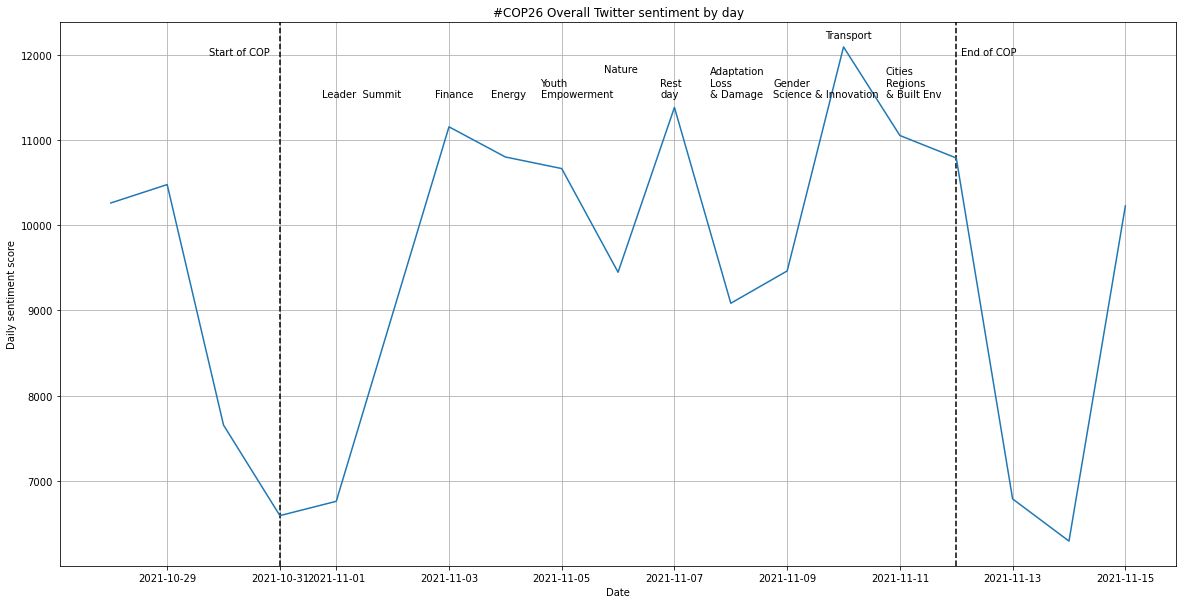

In [127]:
# Plantbasedtreaty    
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
x = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y = anothergoddamnlist
plt.figure(figsize=(20,10))
plt.grid()

# xcoords = [datetime.datetime(2021,11,7), datetime.datetime(2021,11,10)]
# for xc in xcoords:
#     plt.axvline(x=xc, color='r', linestyle='dashed')

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')    
    
    
plt.annotate("Start of COP", (datetime.datetime(2021,10,29, hour=18), 12000))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=2), 12000))
plt.annotate("Leader  Summit", (datetime.datetime(2021,10,31, hour=18), 11500))
plt.annotate("Finance", (datetime.datetime(2021,11,2, hour=18), 11500))
plt.annotate("Energy", (datetime.datetime(2021,11,3, hour=18), 11500))
plt.annotate("Youth\nEmpowerment", (datetime.datetime(2021,11,4, hour=15), 11500))
plt.annotate("Nature", (datetime.datetime(2021,11,5, hour=18), 11800))
plt.annotate("Rest\nday", (datetime.datetime(2021,11,6, hour=18), 11500))
plt.annotate("Adaptation\nLoss\n& Damage", (datetime.datetime(2021,11,7, hour=15), 11500))
plt.annotate("Gender\nScience & Innovation", (datetime.datetime(2021,11,8, hour=18), 11500))
plt.annotate("Transport", (datetime.datetime(2021,11,9, hour=16), 12200))
plt.annotate("Cities\nRegions\n& Built Env", (datetime.datetime(2021,11,10, hour=18), 11500))
    
#plt.xlim(
#    xmin=datetime.datetime(2021, 10, 28), # the one that doesn't change
#    xmax=datetime.datetime(2021, 11, 15) # the latest datetime in your dataset
plt.plot(x, y)

#sample_dates = np.array([datetime.datetime(11,7), datetime.datetime(11,10)])
#plt.vlines(x=sample_dates, ymin=0, ymax=12092, linestyles="dashed", color = 'r')
#fig, ax = plt.subplots()
#ax.set_xlim([datetime.date(2021, 10, 28), datetime.date(2021, 11, 15)])

# plt.annotate("Start of COP", (datetime.datetime(2021,10,31, hour=3), 11500))
# plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 11500))

# plt.annotate("Rest day", (datetime.datetime(2021,11,7, hour=3), 11500))
# plt.annotate("Transportation day", (datetime.datetime(2021,11,10, hour=3), 12150))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Overall Twitter sentiment by day')
plt.savefig('Overallsentiment.png')

### Overall sentiment

I first want to get a sense of the overall sentiment trend throughout the conference. The following graph displays the daily sentiment for all tweets in the dataset.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


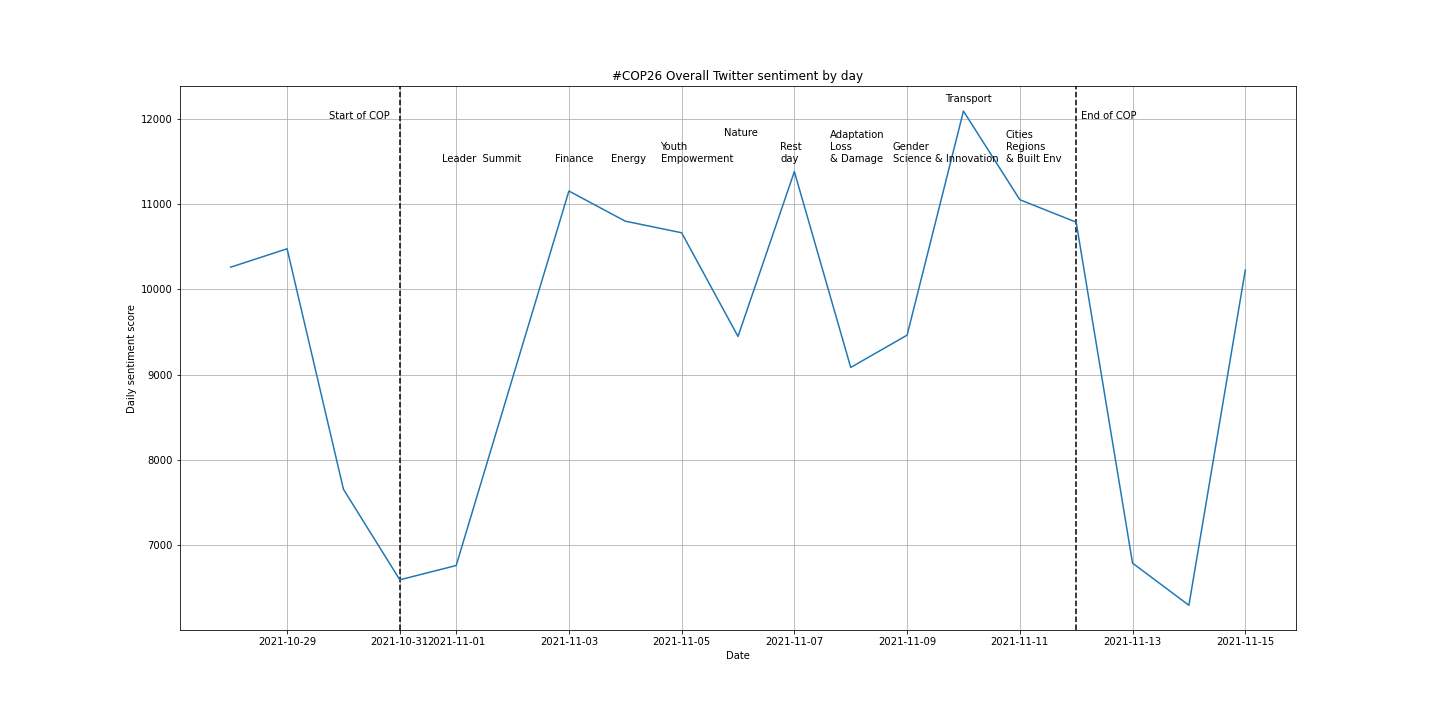

In [128]:
Image('Overallsentiment.png')

### Takeaways

Interesting! Sentiment appears high in the days leading up to the conference, ping-pongs around a bit during, craters into a low after the conference closes on Nov 12, but mysteriously rebounds three days later on Nov 15.

There are three prominent spikes in sentiment during the conference:  
  
11/3: On the first day of actual negotiation, following the first two days of leaders-only meetings.  
11/7: On the rest day.    
11/10: Transportation-focused day. Would have to dig deeper to explain that. 

### Topic Modeling

Now we want to dig in deeper and see if we can find groups of tweets that cluster together by distinct theme. 

We'll accomplish this using LDA (latent dirichlet analysis) modeling. LDA is an unsupervised classification algorithm.

Through trial-and-error I found taking a smaller sample of the full 285k tweets dataset gives nearly identical results, so we'll work with a random sample of 50k tweets instead.

In [21]:
for_modeling_unclean = db.full_text.dropna()
for_modeling = []

for tweet in for_modeling_unclean :
    words = [w for w in tweet.split()]# if w not in cop_sw]
    words = " ".join(words)    
    for_modeling.append(words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
random.seed(1234)
for_modeling = random.sample(for_modeling, 50000)  

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
for_modeling[0:3]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['“Loss and Damage,” our 2nd Episcopal Policy Priority for #COP26, refers to the loss of lives and livelihoods, and damages to homes and infrastructure that frontline communities suffer due to climate change, and the need for financial and political support! https://t.co/2uwDBJLNUP https://t.co/RfJCz5PVSt',
 '@RepYoungKim Zero, zero, zero lol We drive EV, one being a Tesla! We don’t pay for gas ⛽️ But thx for the pollution US Rep Young Kim #COP26 #ca39 #ClimateAction #ClimateCrisis @HouseGOP',
 '"We want action. We want action and justice NOW!" Our kids are crying out to be listened. And they will not tolerate blah-blah-blah. Go, go, go awesome ones. Keep shouting. Keep striking. Keep calling these adults to account. #COP26 #SchoolStrike2021 #ClimateActionNow https://t.co/l2XKjj5uFE']

In [54]:
# Updates spaCy's default stop words list with my additional words. 
stop_list = ['`',"Mr.","Mrs.","Ms."]
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
program_start = time.time()

doc_list = []
allowed_postags=['NOUN','ADJ','VERB','ADV']

# Iterates through each article in the corpus.
for doc in for_modeling :
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append([token.lemma_ for token in pr if token.pos_ in allowed_postags])
    
program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 13.133333333333333 minutes.


In [56]:
id2word = Dictionary(doc_list)  
id2word.filter_extremes(no_below=10, no_above=0.4)  #getting rid of fewer than 10 instances. 
                                # And no more than words that appear in a certain fraction
                                # of the total corpus size (in this case .4)
id2word.compactify()  # assign new word ids to all words. 
corpus = [id2word.doc2bow(word) for word in doc_list]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
num_topics = 10

program_start = time.time()

lda_model = LdaMulticore(corpus=corpus, 
                             id2word=id2word, 
                             num_topics=num_topics, 
                             random_state=1,
                             chunksize=30,
                             passes=40,
                             alpha=0.31,  # sets our priors
                             eta=0.91,
                             eval_every=1,
                             per_word_topics=True,
                             workers=1)

program_end = time.time()
print('Total time taken to run is {} minutes.'.format(round(program_end - program_start)/60, 2))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total time taken to run is 16.316666666666666 minutes.


### LDA Modeling

Through trial and error, I found that asking the LDA model for 10 groups gave me the most valuable breakdown of groups overall, even though a few of the groups themselves aren't that useful. For instance, when restricting the group size down to seven or eight, the Education-focused group gets folded into one of the other groups while another group of fairly random event-focused verbs appears. By expanding the group size to 10 I get more useful distinctions and can get ignore the less-useful groups when I go to interpret the group sentiment. 

In [129]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.033*"do" + 0.024*"have" + 0.020*"go" + 0.017*"say" + 0.016*"want" + '
  '0.015*"just" + 0.014*"be" + 0.013*"think" + 0.013*"only" + 0.011*"well"'),
 (1,
  '0.176*"climate" + 0.061*"change" + 0.051*"need" + 0.044*"now" + '
  '0.044*"action" + 0.040*"take" + 0.018*"call" + 0.018*"help" + '
  '0.017*"crisis" + 0.013*"promise"'),
 (2,
  '0.056*"so" + 0.043*"get" + 0.036*"day" + 0.036*"🏴" + '
  '0.030*"\U000e0067\U000e0062\U000e0073\U000e0063\U000e0074\U000e007f" + '
  '0.024*"last" + 0.020*"good" + 0.019*"much" + 0.018*"back" + 0.017*"too"'),
 (3,
  '0.085*"world" + 0.061*"leader" + 0.036*"’" + 0.029*"people" + '
  '0.024*"planet" + 0.019*"hope" + 0.016*"future" + 0.016*"important" + '
  '0.016*"summit" + 0.014*"hear"'),
 (4,
  '0.061*"fuel" + 0.060*"fossil" + 0.055*"time" + 0.046*"end" + 0.039*"new" + '
  '0.028*"talk" + 0.028*"stop" + 0.028*"government" + 0.027*"big" + '
  '0.027*"need"'),
 (5,
  '0.022*"here" + 0.021*"today" + 0.020*"work" + 0.019*"great" + 0.019*"look" '
  '+

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic groupings
Brief summary of each category and sample of words from each group's output that convey the essence of that group.

Group numbers refer to the LDAvis graphical output to follow, not the LDA model printout that precedes (they are different for an unknown reason, but the graphical output makes interpreting the group differences a bit easier). 

**1) Random:**   
[have / do / make / get / say / think / know ]  
Lots of verbs in this grouping: make, do, get, think, etc. It seems a bit of a random grouping that's picking up on things people are doing, perhaps other things that don't fit into the other groupings. Tough to tell, and there's no real value in this group, but again like the other fairly random grouping above it continues to show up in the model even with the total number of groupings are reduced and other valuable groupings disapper. 
  
  
**2) Education:**  
[ event / join / solution / live / tomorrow / learn / discuss / discussion ]  
This grouping is a bit harder to intuit, but I believe it's picking up on educational events held throughout COP. In addition to the education-focused words shown in the summary, it picks up on climate change topics as well (like "energy", "build", "sustainable", "green", and "nature"), which to me suggests that these educational words tend to co-occur with the topics. This would make sense if this grouping tends to include tweets that are broadcasting information about the various gatherings, seminars, and discussions during the conference about these topics. 

**3) Activism:**  
[commitment / need / activist / action / promise / tackle / crisis / help / justice ]    
This group is clustered around climate activism; tweets calling broadly for action, commitments, climate justice, etc. without being focused on specific policy.  
  
    
**4) Aspirational Policy:**  
[energy / solution / environment / green / renewable / investment / impact / policy / technology / economy / sustainable ]  
This group is clustered around more aspirational climate initiatives and policy. It’s more foward-focused around opportunities, positive impact (create, build, impact, help, etc.) than the End Bad Policy grouping.

**5) End Bad Policy**  
[country / carbon / emission / support / % / global / target / commitment / phase / reduce ]  
This grouping appears policy-focused, similar to Aspiration, but leans more towards phasing out harmful fossil fuel-focused policy rather than forward-looking like Aspiration. Both “more of the good” and “less of the bad” are both valuable discussions, so it’s neat to see the model pick them out. 
  
   
**6) Collaboration:**   
[listen / together / share / community / young / Indigenous / thank ]  
I'm quite excited the model picked up on a group like this, which I'm calling Collaboration: it's distinctly focused on things like sharing, listening, working together, and young & indigenous voices, as compared to the other two action-focused groupings (Fossil fuels & Aspiration). There are also hints that this grouping picks up on themes of gratefulness & hope, judging from words like "great", "thank", "welcome", "full", and "amazing". Very cool.

**7) Event-focused random:**   
[ so / see / week / look / year / many / next / hope ]  
I interpret this cluster as fairly random noise, an artifact of asking the model to return ten clusters. It’s interesting that this cluster continues to show up when I reduce the model groupings from 10 down to nine and eight, while other more intuitively useful clusters stop coming through. 
  
  
**8) Fossil fuels:**  
[fossil / fuel / time / end / stop / government / big ]  
This group is squarely clustered around moving away from fossil fuels. I interpret the inclusion of words like “end”, “phase” and “out” (as in “phase out”), “stop”, and “commit” to show that this grouping is not tweets related to defending fossil fuels but rather focused around the need to phase them out in favor of renewable alternatives. 

**9) National fossil fuels:**  
[water / coal / oil / keep / power / gas / decision / blame / burn / lie]  
This grouping appears quite similar to Fossil Fuels, but the model is perhaps splitting it into a separate group because these are tweets focused around specific national fossil fuel policy in particular, rather than discussing broader policy. The emphasis is on Australian, with one Scottish indicator word also in the mix: "auspol" (Australian politics), “@AngusTaylorMP”, “minister”, “@thesnp" (Scottish National Party), and “australian” are show up as indicator words for this group.
  
  
**10) CTAs / tracking**  
[news / tweet / petition / sign / share / read / post / link / 👇🔊 (i.e. emojis for links) ]    
This group appears to be a mix of CTA-type tweets and one or more automated flight-tracking bots. Words like those highlighted in the summary seem associated with calls-to-action, while “✈”, "ft", and "easyjet" are associated with a flight-tracking bot that likely picked up private jets going to and from the conference.

In [59]:
pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
#pyLDAvis.gensim.prepare(lda_model, corpus, words)
pyLDAvis.gensim_models.prepare(lda_model, corpus,id2word)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.091829  0.065410       1        1  13.479239
5      0.040563  0.200525       2        1  12.111161
1     -0.280313 -0.003905       3        1  11.311596
8     -0.021259  0.089604       4        1  11.169234
7     -0.155818 -0.022398       5        1  11.124396
3      0.004007  0.174512       6        1   9.608378
2      0.181344 -0.040960       7        1   8.576073
4     -0.110238 -0.176677       8        1   8.523729
9      0.084175 -0.218841       9        1   8.082084
6      0.165710 -0.067269      10        1   6.014109, topic_info=              Term          Freq         Total Category  logprob  loglift
2          climate  11756.000000  11756.000000  Default  30.0000  30.0000
80           world   4833.000000   4833.000000  Default  29.0000  29.0000
92    cop26glasgow   3345.000000   3345.000000  Default  28.0000  28.0000
1           change   4104.000000   4104.000000  Default  27.0000  27.0000
95         unknown   2929.000000   2929.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
313              g    173.425010    186.862371  Topic10  -5.3223   2.7364
1863          huge    151.468993    172.653784  Topic10  -5.4576   2.6802
409        welcome    294.114519    528.334719  Topic10  -4.7941   2.2253
104         planet    455.700749   1825.756506  Topic10  -4.3562   1.4231
212            see    216.695371   1842.600369  Topic10  -5.0995   0.6706

[461 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
40        1  0.000828       %
40        2  0.000828       %
40        3  0.000828       %
40        4  0.000828       %
40        5  0.991321       %
...     ...       ...     ...
2024      6  0.000658  󠁧󠁢󠁳󠁣󠁴󠁿
2024      7  0.995021  󠁧󠁢󠁳󠁣󠁴󠁿
2024      8  0.000658  󠁧󠁢󠁳󠁣󠁴󠁿
2024      9  0.000658  󠁧󠁢󠁳󠁣󠁴󠁿
2024     10  0.000658  󠁧󠁢󠁳󠁣󠁴󠁿

[4000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 9, 8, 4, 3, 5, 10, 7])

We seem to get the most information out of the model when setting it to ten groups, but not all ten are interesting from the perspective of sentiment analysis. For that analysis we'll take the six groups that convey useful information.

I predict these six topic groups will generally fall into two sentiment patterns: Collaboration, Education, Activism, and Aspiration will be forward-focused and optimistic, while End Bad Policy and Fossil Fuels will be present-focused with lower average sentiment than the first four. 

**Forward-focused**
- Collaboration
- Education
- Activism
- Aspirational Policy

**Present-focused**
- End Bad Policy
- Fossil Fuels

In [61]:
# create temp lists to pass into dataframe
tweetlist = []
categorylist = []
probabilitylist = []
topic_assignments = []


# Calculate topic probabilities for each tweet & assign tweets to categories
for tweet in for_modeling :
    doc = [w for w in tweet.split()]
    pr = nlp(" ".join(doc))
    doc = [token.lemma_ for token in pr if token.pos_ in allowed_postags]
    doc_new = id2word.doc2bow(doc)

    topic_probs = lda_model[doc_new][0]
    topic = max(topic_probs,key=lambda x: x[1])
    topic_assignments.append(topic[0])    
    prob = max(topic_probs)
    cat = topic[0]
    prob = topic[1]
    tweetlist.append(tweet)
    categorylist.append(cat)
    probabilitylist.append(prob)

tweets_df = pd.DataFrame()
tweets_df["Tweet"] = tweetlist
tweets_df["Category"] = categorylist
tweets_df["Probability"] = probabilitylist

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
tweets_df

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet,Category,Probability
0,"“Loss and Damage,” our 2nd Episcopal Policy Pr...",4,0.236143
1,"@RepYoungKim Zero, zero, zero lol We drive EV,...",8,0.252813
2,"""We want action. We want action and justice NO...",0,0.350488
3,It's infuriating to hear Boris Johnson talk cl...,4,0.245590
4,BBC News: #COP26: #Greta #Thunberg tells prote...,0,0.476629
...,...,...,...
49995,'Urban Transitions' is one of four 'Missions' ...,8,0.670348
49996,"Accompanied by their 'serpent of capitalism', ...",1,0.312243
49997,Thanks $BEACH for kicking A$$ and making a dif...,9,0.430818
49998,Looking forward to the @LFINupdates #Diwali re...,5,0.587628


In [84]:
newdf = tweets_df.merge(db, left_on='Tweet', right_on='full_text', how='inner')
newdf = newdf.drop_duplicates(subset=['tweet_id'], keep='first')
newdf["date_created"] = pd.to_datetime(newdf["date_created"], format="%Y-%m-%d") 
newdf['days'] = newdf['date_created'].dt.date

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# rename columns from numbers to actual names for final display

newdf['Category'] = newdf['Category'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                                            ['Random','Activism','Event-focused random','Collaboration',
                                                             'Fossil Fuels', 'Education','CTAs & tracking',
                                                             'End Bad Policy','Aspirational Policy','National FF Policy'])
                                                             


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
newdf_groupby_category = newdf.groupby('Category')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
print(f"Number of tweets per category")
print(newdf_groupby_category.size())

Number of tweets per category
Category
Activism                1352
Aspirational Policy     1541
CTAs & tracking          337
Collaboration           1160
Education               2628
End Bad Policy          1554
Event-focused random    1129
Fossil Fuels             792
National FF Policy       821
Random                  2844
dtype: int64


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
newdf_collab = newdf_groupby_category.get_group('Collaboration')
newdf_aspiration = newdf_groupby_category.get_group('Aspirational Policy')
newdf_education = newdf_groupby_category.get_group('Education')
newdf_activism = newdf_groupby_category.get_group('Activism')

newdf_fossil = newdf_groupby_category.get_group('Fossil Fuels')
newdf_endbadpolicy = newdf_groupby_category.get_group('End Bad Policy')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
from datetime import date, timedelta
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2021, 10, 28)
end_date = date(2021, 11, 16)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# John - I tried condensing the code into a function but couldn't squash this bug. 
# The function is returning the scores list 3x over for each topic_df...??????

# scores = []

# def sentiment_bytopic(topicdf):
#     for single_date in daterange(start_date, end_date):
#         current = 0  # resets current var to zero between each speaker or night loop
#         for tweet in topicdf[topicdf["days"] == single_date].Tweet.unique():
#             line_b = tweet.split(' ')
#             for idx, word in enumerate(line_b):
#                 if word in sentiment_scores:
#                     current += sentiment_scores[word.lower()]
#         scores.append(current)
#     return(scores)


# actionlist = sentiment_bytopic(newdf_action)
# randomlist = sentiment_bytopic(newdf_random)
# policylist = sentiment_bytopic(newdf_policy)
            

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
collablist = []
aspirationlist = []
educationlist = []
activismlist = []

fossillist = []
endbadpolicylist = []

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_collab[newdf_collab["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    collablist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_activism[newdf_activism["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    activismlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_aspiration[newdf_aspiration["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    aspirationlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_education[newdf_education["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    educationlist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:

for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_fossil[newdf_fossil["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    fossillist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
for single_date in daterange(start_date, end_date):
    current = 0  # resets current var to zero between each speaker or night loop
    for tweet in newdf_endbadpolicy[newdf_endbadpolicy["days"] == single_date].Tweet.unique():
        line_b = tweet.split(' ')
        for idx, word in enumerate(line_b):
            if word in sentiment_scores:
                current += sentiment_scores[word.lower()]
    endbadpolicylist.append(current)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


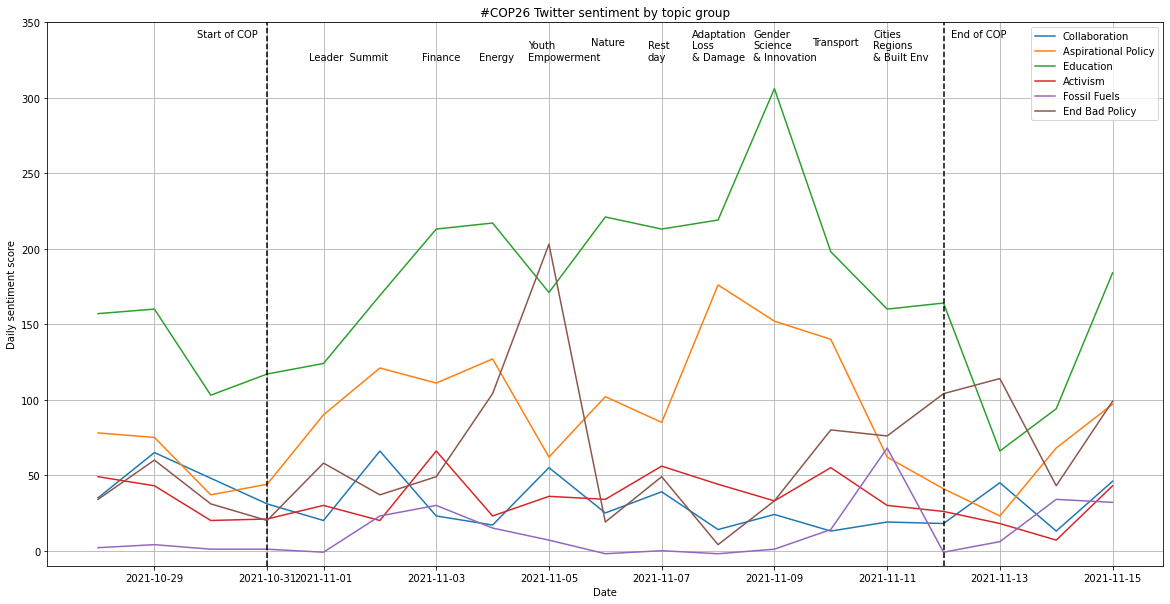

In [113]:
# Set parameters for sentiment-by-group plot

x1 = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

y1=collablist
y2=aspirationlist
y3=educationlist
y4=activismlist
y5=fossillist
y6=endbadpolicylist

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(x1, y1, label="Collaboration")

x2 = x1
plt.plot(x2, y2, label="Aspirational Policy")

x3 = x1
plt.plot(x3, y3, label="Education")

x4 = x1
plt.plot(x4, y4, label="Activism")

x5 = x1
plt.plot(x5, y5, label="Fossil Fuels")

x6 = x1
plt.plot(x6, y6, label="End Bad Policy")

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')

plt.annotate("Start of COP", (datetime.datetime(2021,10,29, hour=18), 340))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 340))
plt.annotate("Leader  Summit", (datetime.datetime(2021,10,31, hour=18), 325))
plt.annotate("Finance", (datetime.datetime(2021,11,2, hour=18), 325))
plt.annotate("Energy", (datetime.datetime(2021,11,3, hour=18), 325))
plt.annotate("Youth\nEmpowerment", (datetime.datetime(2021,11,4, hour=15), 325))
plt.annotate("Nature", (datetime.datetime(2021,11,5, hour=18), 335))
plt.annotate("Rest\nday", (datetime.datetime(2021,11,6, hour=18), 325))
plt.annotate("Adaptation\nLoss\n& Damage", (datetime.datetime(2021,11,7, hour=13), 325))
plt.annotate("Gender\nScience\n& Innovation", (datetime.datetime(2021,11,8, hour=15), 325))
plt.annotate("Transport", (datetime.datetime(2021,11,9, hour=16), 335))
plt.annotate("Cities\nRegions\n& Built Env", (datetime.datetime(2021,11,10, hour=18), 325))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Twitter sentiment by topic group')
plt.legend(loc = "upper right")
plt.ylim(-10, 350)
#plt.show()
plt.savefig('Groupsentiment.png')


### Sentiment analysis by topic group

Now that we've broken out the tweets by group and day of conference we can graph the sentiment trends.

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


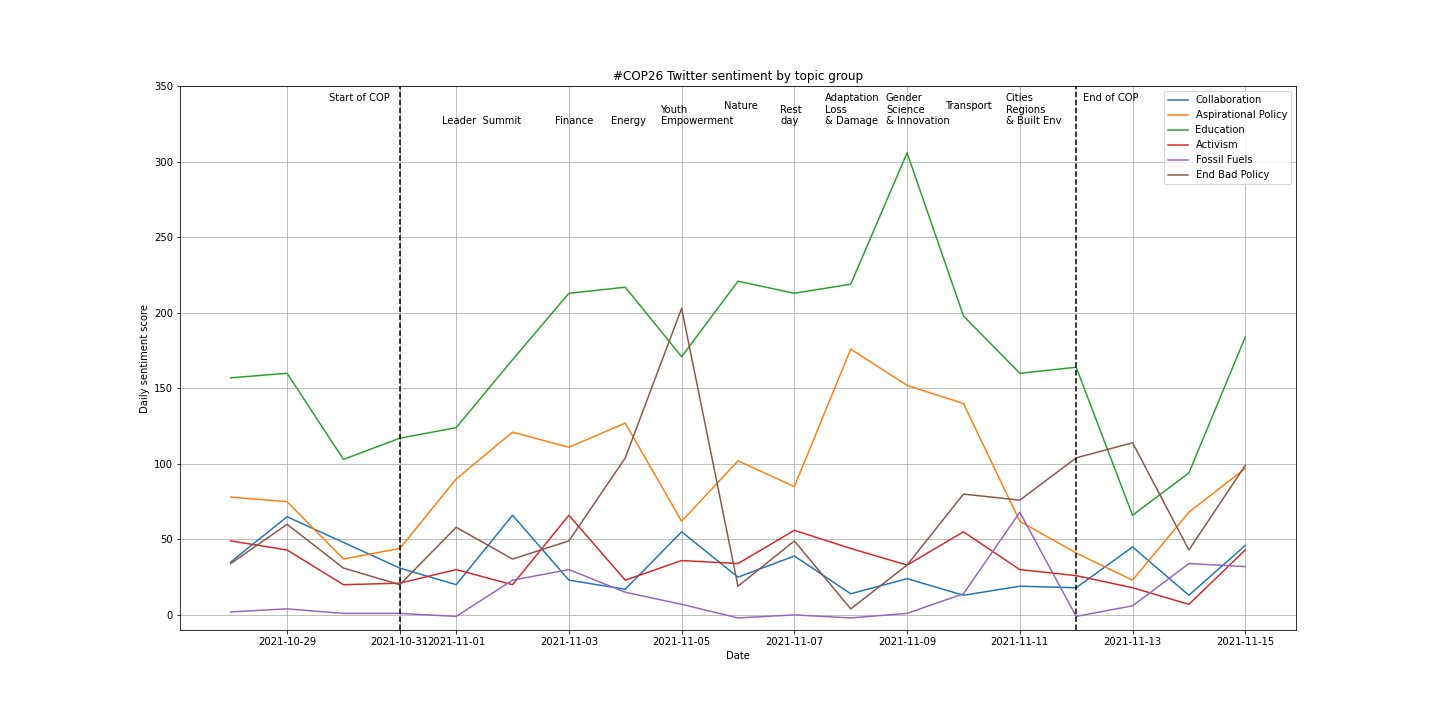

In [131]:
Image('Groupsentiment.png')

### Main takeaways

**Hypothesis mostly confirmed**  
To reiterate, my hypothesis was that seemingly more future-focused groups like Collaboration, Aspirational Policy, Education, and Activism would have higher average sentiment than the more present-focused groups Fossil Fuels and End Bad Policy.

While Education lapped the field for high sentiment throughout the conference and Aspirational Policy had the second-highest score, the Activism and End Bad Policy groups came through differently than expected, with End Bad Policy actually scoring a higher average sentiment than Activism. 

| Group  | Avg Sentiment |
|---|---|
| Education | 171.4 | 
| Aspirational Policy | 89 | 
| End Bad Policy | 64 | 
| Activism | 34.4 | 
| Collaboration | 32.4 | 
| Fossil Fuels | 12.2 | 

### Takeaways, cont'd
  
**Youth / climate justic days = higher sentiment**  
We see three main spikes in sentiment during the conference: in End Bad Policy on the Youth Empowerment day, in Aspirational Policy on the Adaptation, Loss & Damage day, and in Education on the Gender, Science & Tech day. In my mind, these spikes in sentiment show that when the focus in on youth or climate justice, sentiment tends to be higher than normal. It appears the youth have more hope for the future than the older generations that have gotten us into this mess. 
  
**Lots of noise, but some signals**  
There's a decent amount of noise in this graph. For instance, it's not immediately apparent if the Collaboration line provides any valuable information, or at a broader level if the smaller ups and downs in the group sentiments are valuable reflections of the work being done at COP26 or some amount of natural variation in sentiment. We would need to analyze tweets over a longer timeframe to get a better sense here.  

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


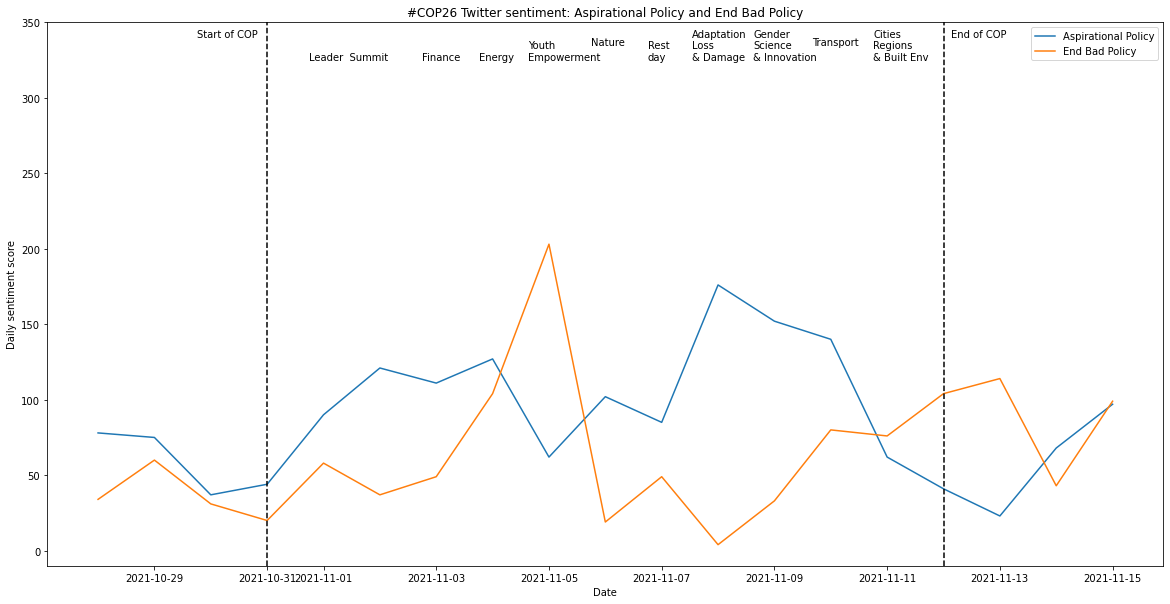

In [122]:
# Set parameters for sentiment-by-group plot

x1 = [datetime.datetime(2021,10,28),datetime.datetime(2021,10,29),datetime.datetime(2021,10,30),
     datetime.datetime(2021,10,31),datetime.datetime(2021,11,1),datetime.datetime(2021,11,2),
     datetime.datetime(2021,11,3),datetime.datetime(2021,11,4),datetime.datetime(2021,11,5),
     datetime.datetime(2021,11,6),datetime.datetime(2021,11,7),datetime.datetime(2021,11,8),
     datetime.datetime(2021,11,9),datetime.datetime(2021,11,10),datetime.datetime(2021,11,11),
     datetime.datetime(2021,11,12),datetime.datetime(2021,11,13),datetime.datetime(2021,11,14),
     datetime.datetime(2021,11,15)]

# y1=collablist
y2=aspirationlist
# y3=educationlist
# y4=activismlist
# y5=fossillist
y6=endbadpolicylist

plt.figure(figsize=(20,10))
# plt.grid()
# plt.plot(x1, y1, label="Collaboration")

x2 = x1
plt.plot(x2, y2, label="Aspirational Policy")

# x3 = x1
# plt.plot(x3, y3, label="Education")

# x4 = x1
# plt.plot(x4, y4, label="Activism")

# x5 = x1
# plt.plot(x5, y5, label="Fossil Fuels")

x6 = x1
plt.plot(x6, y6, label="End Bad Policy")

confcoords = [datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)]
for xc in confcoords:
    plt.axvline(x=xc, color='black', linestyle='dashed')

plt.annotate("Start of COP", (datetime.datetime(2021,10,29, hour=18), 340))
plt.annotate("End of COP", (datetime.datetime(2021,11,12, hour=3), 340))
plt.annotate("Leader  Summit", (datetime.datetime(2021,10,31, hour=18), 325))
plt.annotate("Finance", (datetime.datetime(2021,11,2, hour=18), 325))
plt.annotate("Energy", (datetime.datetime(2021,11,3, hour=18), 325))
plt.annotate("Youth\nEmpowerment", (datetime.datetime(2021,11,4, hour=15), 325))
plt.annotate("Nature", (datetime.datetime(2021,11,5, hour=18), 335))
plt.annotate("Rest\nday", (datetime.datetime(2021,11,6, hour=18), 325))
plt.annotate("Adaptation\nLoss\n& Damage", (datetime.datetime(2021,11,7, hour=13), 325))
plt.annotate("Gender\nScience\n& Innovation", (datetime.datetime(2021,11,8, hour=15), 325))
plt.annotate("Transport", (datetime.datetime(2021,11,9, hour=16), 335))
plt.annotate("Cities\nRegions\n& Built Env", (datetime.datetime(2021,11,10, hour=18), 325))

plt.xlabel("Date")
plt.ylabel("Daily sentiment score")
plt.title('#COP26 Twitter sentiment: Aspirational Policy and End Bad Policy')
plt.legend(loc = "upper right")
plt.ylim(-10, 350)
#plt.show()
plt.savefig('Asp_EndBad_sentiment.png')


### Takeaways, cont'd  
   
   
**Every category except End Bad Policy trended downward during the last leg of the conference**  
It doesn't intuitively make sense why the EBP group would buck a trend that affects the other five groups. But from the viewpoint of analysis validity, it is heartening to see the individual group sentiment trends over the last few days of the conference mirror the overall sentiment found earlier.
  
    
**End Bad Policy and Aspirational Policy are inversely related**  
These two groups appear at least somewhat inversely related; as sentiment for one rises the other drops. My hunch is that a lot of the same people who are tweeting about ending bad policy also tweet about aspirational. A good data point about how these are substantially different groupings, as you can see in the following visual:

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


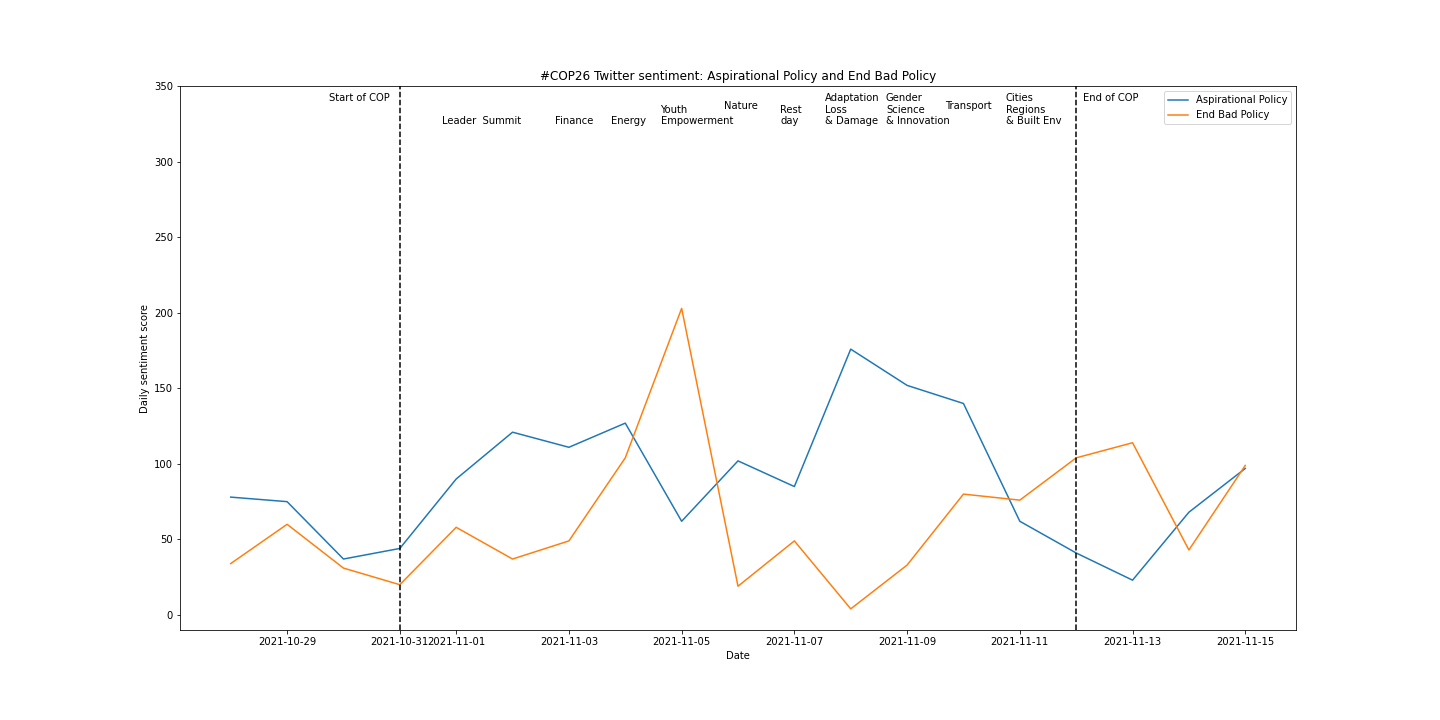

In [123]:
Image('Asp_EndBad_sentiment.png')

### Conclusion
  
In conjunction, topic modeling via LDA analysis coupled with sentiment analysis can provide a useful look into unstructured data, like this dataset of tweets related to COP26. 

We find that people are using Twitter to tweet about a range of themes related to the conference, and that sentiment within each of these themes somewhat tracks to the actual proceedings of the conference.  

In [116]:
sum(collablist) / len(collablist)
sum(aspirationlist) / len(aspirationlist)
sum(activismlist) / len(activismlist)
sum(educationlist) / len(educationlist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


32.421052631578945

In [117]:
sum(fossillist) / len(fossillist)
sum(endbadpolicylist) / len(endbadpolicylist)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


89.0